# PCA

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm


In [0]:
np.random.seed(0)

# init some height data of 90 observations
height = np.concatenate((
    truncnorm(-1, 1, loc=160, scale=7).rvs(30), # the first 30 people have a mean height of 160 cm, normally distributed from 153 to 167
    truncnorm(-1, 1, loc=170, scale=7).rvs(30), # the second group of 30 people have a mean height of 170 cm, distributed from 163 to 177
    truncnorm(-1, 1, loc=180, scale=7).rvs(30), # and so on, distributed from 173 to 187
))

In [0]:
# give these people some weight
weight = np.zeros(90)
for i in [0, 30, 60]:
    a = i; b = a + 10
    weight[a:b] = 20 * (height[a:b] / 100) ** 2 + np.random.normal(0, 5 + i / 30, 10) # these people have a healthy weight, BMI ~ 20
    
    a = i + 10; b = a + 10
    weight[a:b] = 25 * (height[a:b] / 100) ** 2 + np.random.normal(0, 5 + i / 30, 10) # these people are overweight
    
    a = i + 20; b = a + 10
    weight[a:b] = 30 * (height[a:b] / 100) ** 2 + np.random.normal(0, 5 + i / 30, 10) # these people are obese

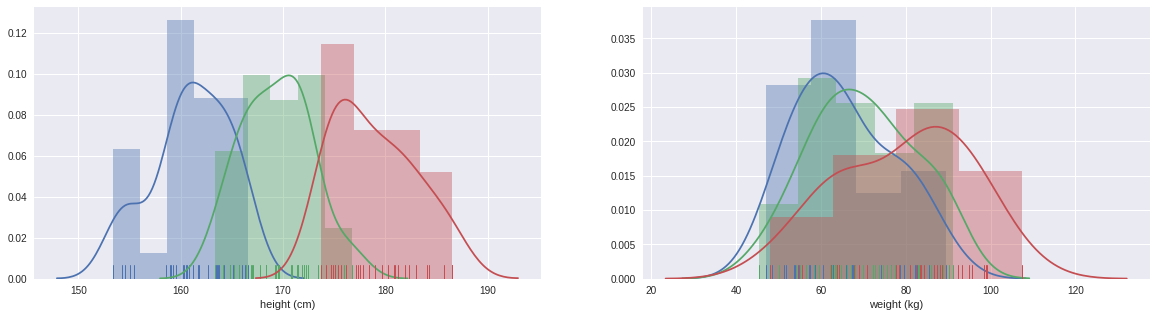

In [72]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
for i in [0, 30, 60]:
    for index, data, axlabel in [(0, height, 'height (cm)'), (1, weight, 'weight (kg)')]:        
        _ = sns.distplot(
            data[i:(i + 30)],
            kde=True, rug=True,
            axlabel=axlabel,
            ax=ax[index]
        )

So we have a group of people, each person have 2 characteristics: height and weight. We have:
- person 1: 160 cm, 45 kg
- person 2: 162 cm, 57 kg and so so



In [0]:
people = pd.DataFrame({ 'height': height, 'weight': weight })

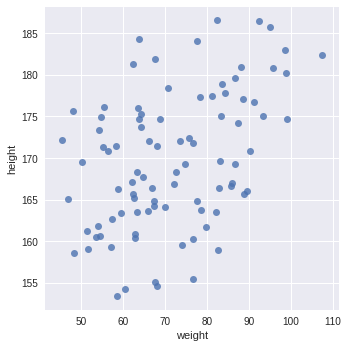

In [81]:
_ = sns.lmplot(x='weight', y='height', data=data, fit_reg=False)

In [87]:
np.cov(height, weight)

array([[ 67.61420587,  50.88143021],
       [ 50.88143021, 205.50975327]])